In [1]:
# read data
import random
import numpy as np
import pymc3 as pm

data = np.loadtxt("data/txtdata.csv")
n_obs = len(data)

# day index
idx = np.arange(n_obs)

# set seed
random.seed(42)

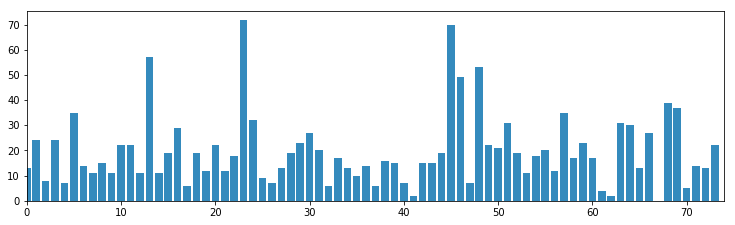

In [2]:
# plot data
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

figsize(12.5, 3.5)
plt.bar(np.arange(n_obs), data, color="#348ABD")
plt.xlim(0, n_obs);

In [3]:
# define model
with pm.Model() as model:
    # hyper parameters
    alpha = 1/data.mean()
    
    # parameters
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_obs)
    lambda1 = pm.Exponential("lambda1", alpha)
    lambda2 = pm.Exponential("lambda2", alpha)
    lambda_i = pm.math.switch(tau >= idx, lambda1, lambda2)
    
    # observations
    obs = pm.Poisson("obs", lambda_i, observed=data)
    
    # predictive dists
    pred1 = pm.Poisson("pred1", lambda1)
    pred2 = pm.Poisson("pred2", lambda2)

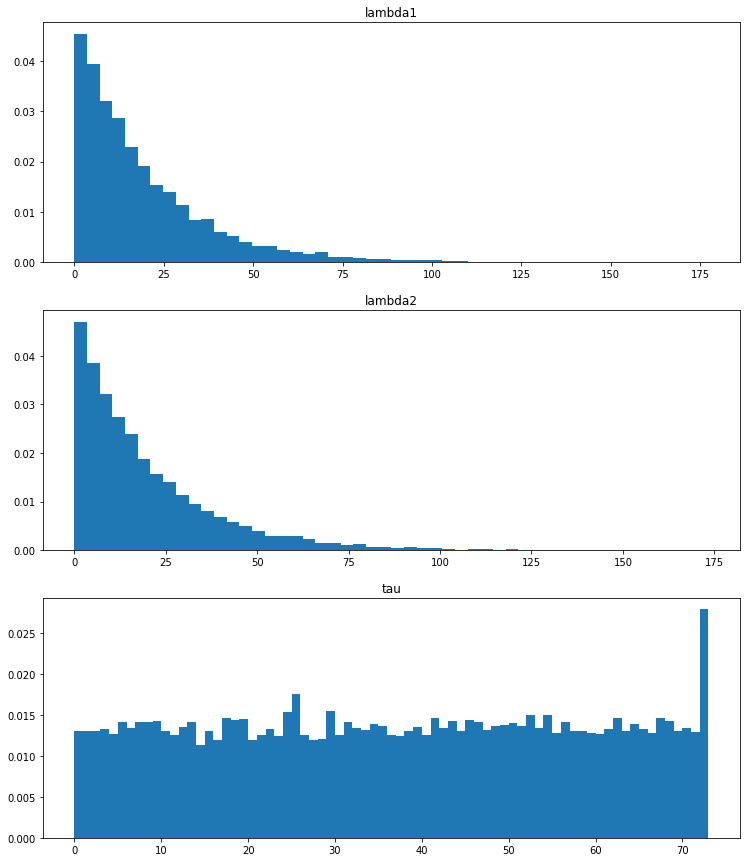

In [4]:
# plot priors
def plot_dist(dist, n = 10000, label = None, bins = 50):
    samples = [dist.random()[0] for i in np.arange(n)]
    
    
    plt.hist(samples, bins=bins, normed=True, histtype="stepfilled")
    plt.title(dist.name if label is None else label)
    
figsize(12.5, 15)
ax = plt.subplot(311)
plot_dist(lambda1)
ax = plt.subplot(312)
plot_dist(lambda2)
ax = plt.subplot(313)
plot_dist(tau, bins=73)

# notar que lambda_i es igual a lambda1 y lambda2 a priori

In [5]:
    # perform inference
    with model:
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step)


100%|██████████| 10000/10000 [00:04<00:00, 2316.32it/s]


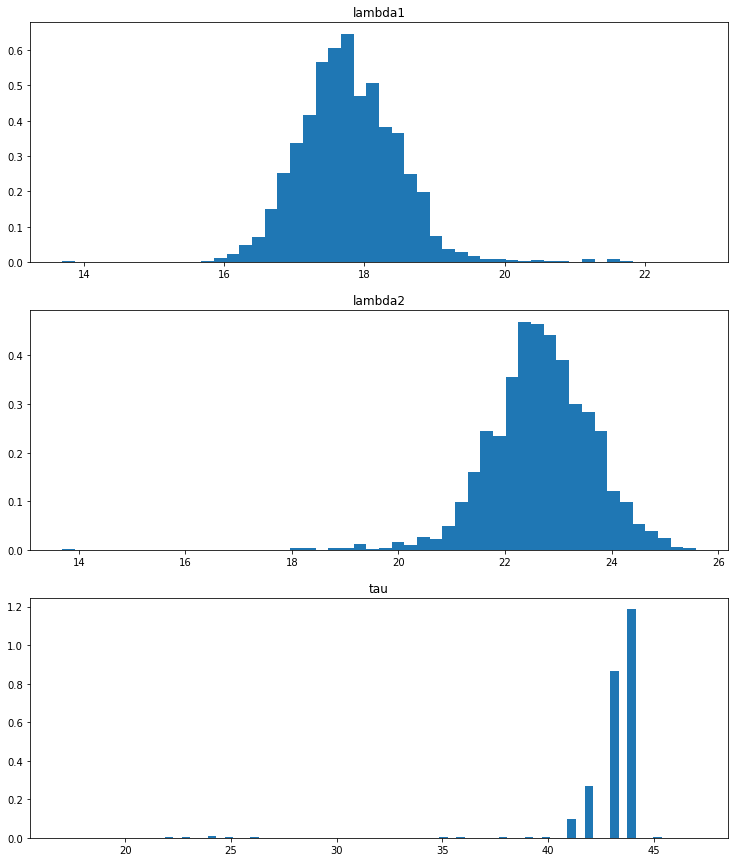

In [6]:
# plot posteriors
def plot_trace(trace, name, bins = 50):
    samples = trace[name]
    label = name
    
    plt.hist(samples, bins = bins, normed = True, histtype = "stepfilled")
    plt.title(label)
    
ax = plt.subplot(311)
plot_trace(trace, "lambda1")
ax = plt.subplot(312)
plot_trace(trace, "lambda2")
ax = plt.subplot(313)
plot_trace(trace, "tau", bins = n_obs)
    

<Container object of 74 artists>

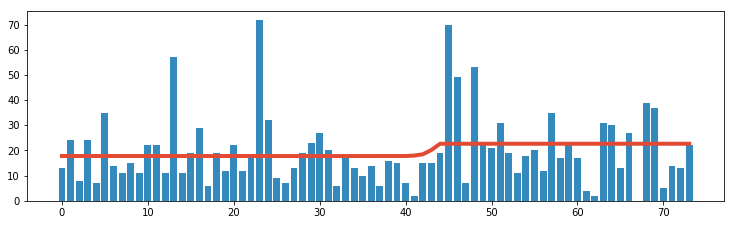

In [7]:
# compute expected parameter value (lambda_i) 
expected = np.zeros(n_obs)
for i, day in enumerate(idx):
    before = day < trace["tau"]
    expected[i] = (trace["lambda1"][before].sum() + trace["lambda2"][~before].sum())/len(trace)
    
figsize(12.5, 3.5)
plt.plot(range(n_obs), expected, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.bar(idx, data, color = "#348ABD")

In [8]:
print("Expected L1: {0}".format(trace["lambda1"].mean()))

print("Expected L2: {0}".format(trace["lambda2"].mean()))

print("Expected tau: {0}".format(trace["tau"].mean()))

print("Expected difference: {0}".format((trace["lambda2"]-trace["lambda1"]).mean()))

print("Expected % increase: {0}".format((trace["lambda2"]/trace["lambda1"]).mean()))

print("Probability L2 > L1: {0}".format((trace["lambda2"] > trace["lambda1"]).mean()))

print("Probability tau = 44: {0}".format((trace["tau"] == 44).mean()))

print((trace["pred1"] > 20).mean())

print((trace["pred2"] > 20).mean())



Expected L1: 17.78916798570392
Expected L2: 22.669546949779832
Expected tau: 43.0421
Expected difference: 4.880378964075918
Expected % increase: 1.2766366919382934
Probability L2 > L1: 0.9914
Probability tau = 44: 0.4808
0.2478
0.6715


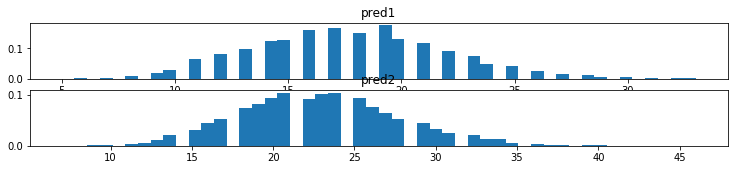

In [9]:
    
ax = plt.subplot(311)
plot_trace(trace, "pred1")
ax = plt.subplot(312)
plot_trace(trace, "pred2")

In [10]:
import pandas as pn
x = pn.DataFrame({"lambda1": trace["lambda1"], "lambda2": trace["lambda2"],
              "tau": trace["tau"], "pred1": trace["pred1"], "pred2": trace["pred2"]})
x.to_csv("data/posteriors.csv")
